In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [2]:
data_path = 'mitdb/'

In [3]:
# Lists of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [4]:
import wfdb

In [5]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)
    

In [6]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [7]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [8]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [9]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [10]:
#a function for loading a single patient's signals and annotations
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [11]:
file = data_path + pts[0]

In [12]:
#Calling a function
p_signal, atr_sym, atr_sample = load_ecg(file)


In [13]:

values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [14]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [15]:
x = np.arange(len(p_signal))

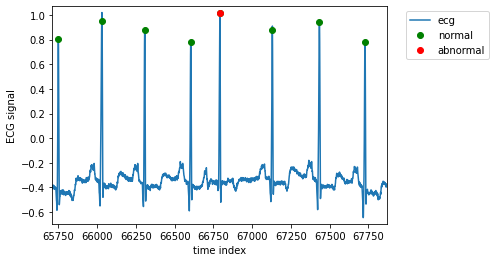

In [16]:
left = ab_index[1]-1080
right = ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [17]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
     # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [18]:
num_sec = 3
fs = 360

In [19]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_valid))

36 12


In [20]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

In [24]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2520/2520 [==============================] - 22s 3ms/step - loss: 0.3113 - accuracy: 0.8784
Epoch 2/5
2520/2520 [==============================] - 4s 1ms/step - loss: 0.1479 - accuracy: 0.9552
Epoch 3/5
2520/2520 [==============================] - 3s 1ms/step - loss: 0.1268 - accuracy: 0.9630
Epoch 4/5
2520/2520 [==============================] - 3s 1ms/step - loss: 0.1169 - accuracy: 0.9663
Epoch 5/5
2520/2520 [==============================] - 3s 1ms/step - loss: 0.1111 - accuracy: 0.9677


In [26]:
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)

891/891 [==============================] - 1s 821us/step


In [30]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [38]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [43]:

print('Train');
print_report(y_train, y_train_preds_dense, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_dense, thresh);


Train
AUC:0.993
accuracy:0.977
recall:0.951
precision:0.973
specificity:0.989
prevalence:0.299
 
Valid
AUC:0.849
accuracy:0.746
recall:0.354
precision:0.850
specificity:0.965
prevalence:0.358
 


In [33]:
# CNN- Classification using 

# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [34]:
from keras.layers import Conv1D

In [35]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [36]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 3, verbose = 1)

Epoch 1/3
2520/2520 [==============================] - 688s 271ms/step - loss: 0.2716 - accuracy: 0.9001
Epoch 2/3
2520/2520 [==============================] - 656s 260ms/step - loss: 0.1237 - accuracy: 0.9635
Epoch 3/3
2520/2520 [==============================] - 630s 250ms/step - loss: 0.0917 - accuracy: 0.9716


In [51]:
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 38s 42ms/step


In [52]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.994
accuracy:0.963
recall:0.976
precision:0.906
specificity:0.957
prevalence:0.299
 
Valid
AUC:0.898
accuracy:0.803
recall:0.854
precision:0.679
specificity:0.775
prevalence:0.358
 
